In [2]:
import pandas as pd
dt = pd.read_csv('propaganda_train.tsv',sep='\t')
dt1 = pd.read_csv('propaganda_val.tsv',sep='\t')
dt.head()


,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from nltk.corpus import stopwords
import nltk
import re`
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from sklearn.metrics import f1_score
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Activation,Dropout
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,LSTM

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Unnamed: 0,data,target
0,0,"No, <BOS> he <EOS> will not be confirmed.",1
1,1,This declassification effort <BOS> won’t make ...,1
2,2,The Obama administration misled the <BOS> Amer...,0
3,3,“It looks like we’re capturing the demise of t...,1
4,4,"<BOS> Location: Westerville, Ohio <EOS>",1


In [4]:
dt = df.drop(['Unnamed: 0'],axis=1)

In [5]:
dt.head()

,data,target
0,"No, <BOS> he <EOS> will not be confirmed.",1
1,This declassification effort <BOS> won’t make ...,1
2,The Obama administration misled the <BOS> Amer...,0
3,“It looks like we’re capturing the demise of t...,1
4,"<BOS> Location: Westerville, Ohio <EOS>",1


In [6]:
from copy import copy
train = dt.copy()

In [7]:
train.isnull().sum().sort_values(ascending = False)

data      0
target    0
dtype: int64

In [8]:
# function to draw bar plot
def draw_bar_plot(category,length,xlabel,ylabel,title,sub):
    plt.subplot(2,2,sub)
    plt.bar(category, length)
    plt.legend()
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=15)
    #plt.show()

In [9]:
# function to draw histogram
def draw_hist(xlabel, ylabel,title,target,sub,color):
    plt.subplot(1,2,sub)
    plt.hist(train[train.target==target]["length"],color = color)
    plt.title(title,fontsize=25)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    plt.ylim(0,1200)
    plt.grid()

In [10]:
# function to draw graphs for stopwords and punctuations
def draw_bar_n_plot(data,title):
# lets visualize the top 10 stop words
    x,y=zip(*data)

    plt.figure(figsize = (25,10))
    plt.subplot(1,2,1)
    plt.bar(x,y)
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(x,y,'g')
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

In [11]:
print("No. of propoganda (Target = 1):",len(train[train["target"]==1]))
print("No. of not propoganda (Target = 0):",len(train[train["target"]==0]))

No. of propoganda (Target = 1): 1191
No. of not propoganda (Target = 0): 1223


<AxesSubplot:>

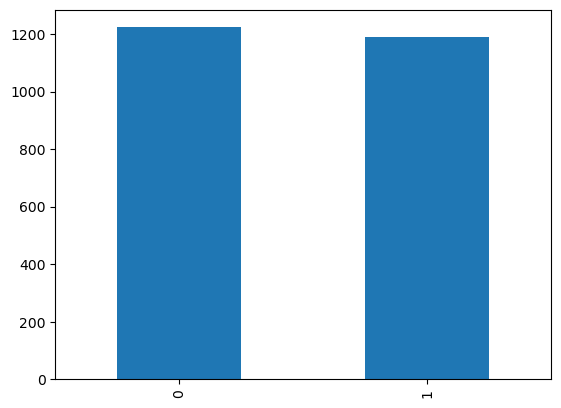

In [12]:
train["target"].value_counts().plot(kind="bar")

In [13]:
def length(data):    
    return len(data)

train["length"]= train.data.apply(length)


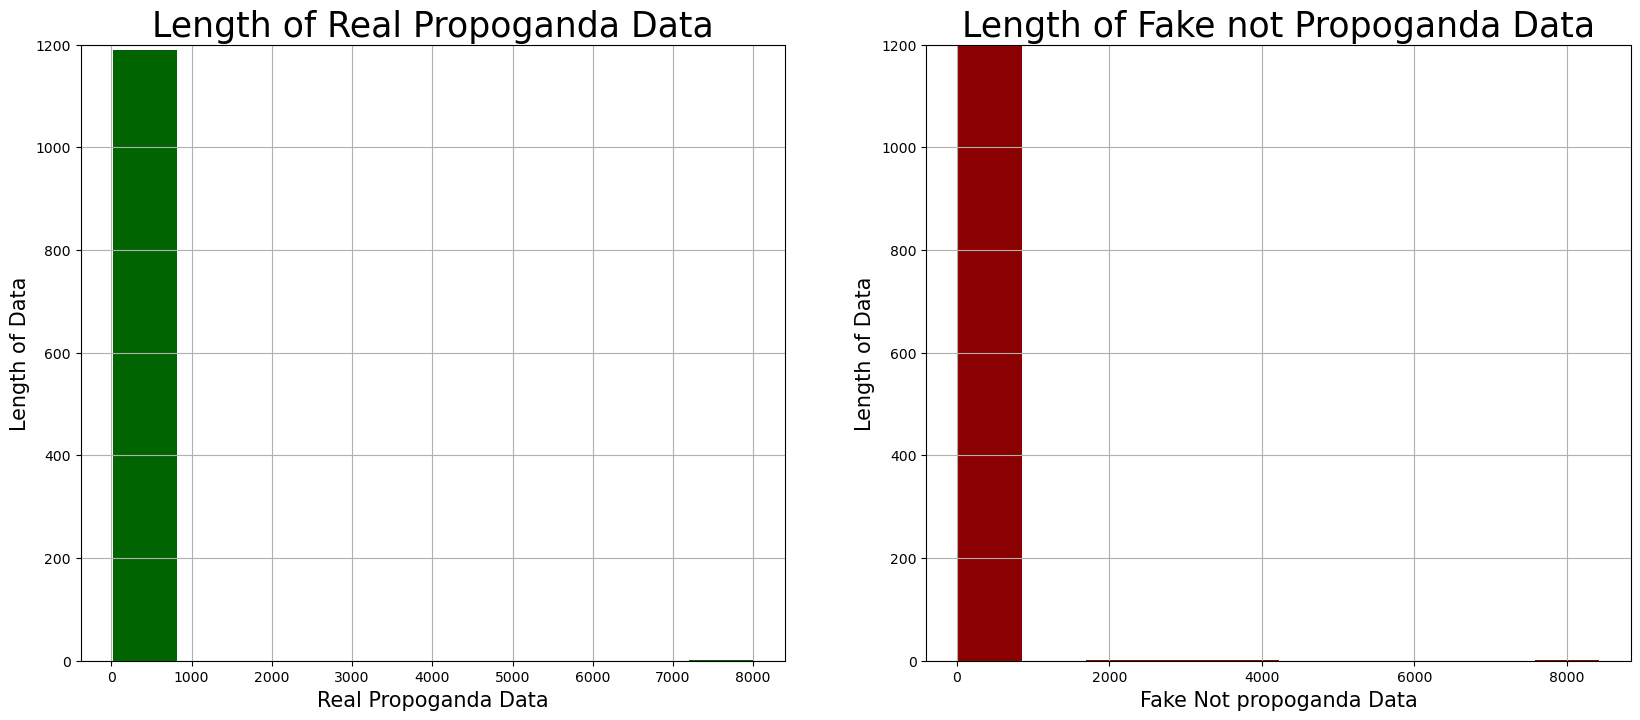

In [14]:
plt.figure(figsize = (20,8))
draw_hist("Real Propoganda Data","Length of Data","Length of Real Propoganda Data",1, 1,"darkgreen")
draw_hist("Fake Not propoganda Data","Length of Data","Length of Fake not Propoganda Data",0, 2,"darkred")

In [15]:
# lets check the average lenght of real vs fake tweets
print(train.groupby("target").mean()["length"].sort_values(ascending = False))

target
0    206.753884
1    145.171285
Name: length, dtype: float64


In [16]:
train.drop("length",1,inplace=True)

C:\Users\khyber\AppData\Local\Temp\ipykernel_12052\305933883.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train.drop("length",1,inplace=True)


In [17]:
train.head()

,data,target
0,"No, <BOS> he <EOS> will not be confirmed.",1
1,This declassification effort <BOS> won’t make ...,1
2,The Obama administration misled the <BOS> Amer...,0
3,“It looks like we’re capturing the demise of t...,1
4,"<BOS> Location: Westerville, Ohio <EOS>",1


In [18]:
train.rename(columns = {'data':'text'}, inplace = True)

In [19]:
stop = list(stopwords.words("english"))

In [20]:
# stopwords present in the whole dataset
sw = []
for message in train.text:
    for word in message.split():
        if word in stop:
            sw.append(word)


# lets convert the list to a dictinoary which would contain the stop words and their frequency
wordlist = nltk.FreqDist(sw)
# lets save the 10 most frequent stopwords
top10 = wordlist.most_common(10)

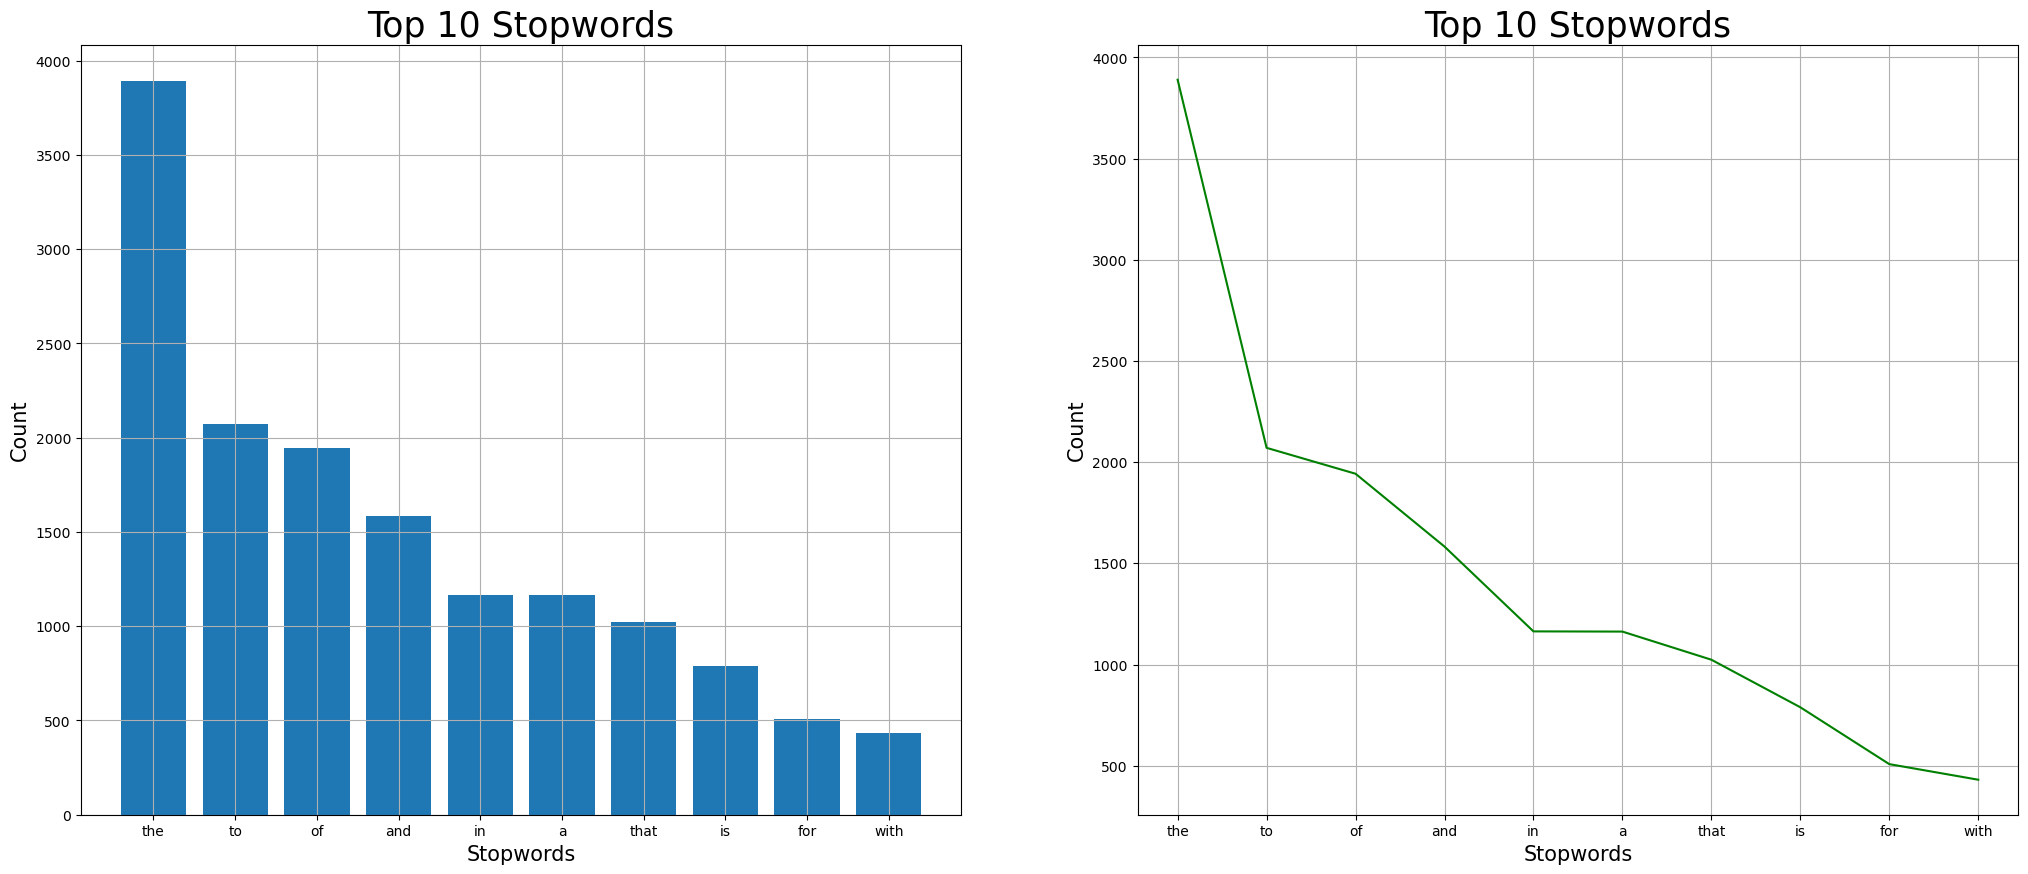

In [21]:
draw_bar_n_plot(top10,"Stopwords")

In [22]:
punctuation = list(string.punctuation)

In [23]:
# punctuations present in all the tweets 
pun = []
for message in train.text:
    for word in message.split():
        if word in punctuation:
            pun.append(word)


# lets convert the list to a dictinoary which would contain the punctuations and their frequency
wordlist = nltk.FreqDist(pun)
# lets save the 10 most frequent stopwords
top10 = wordlist.most_common(10)

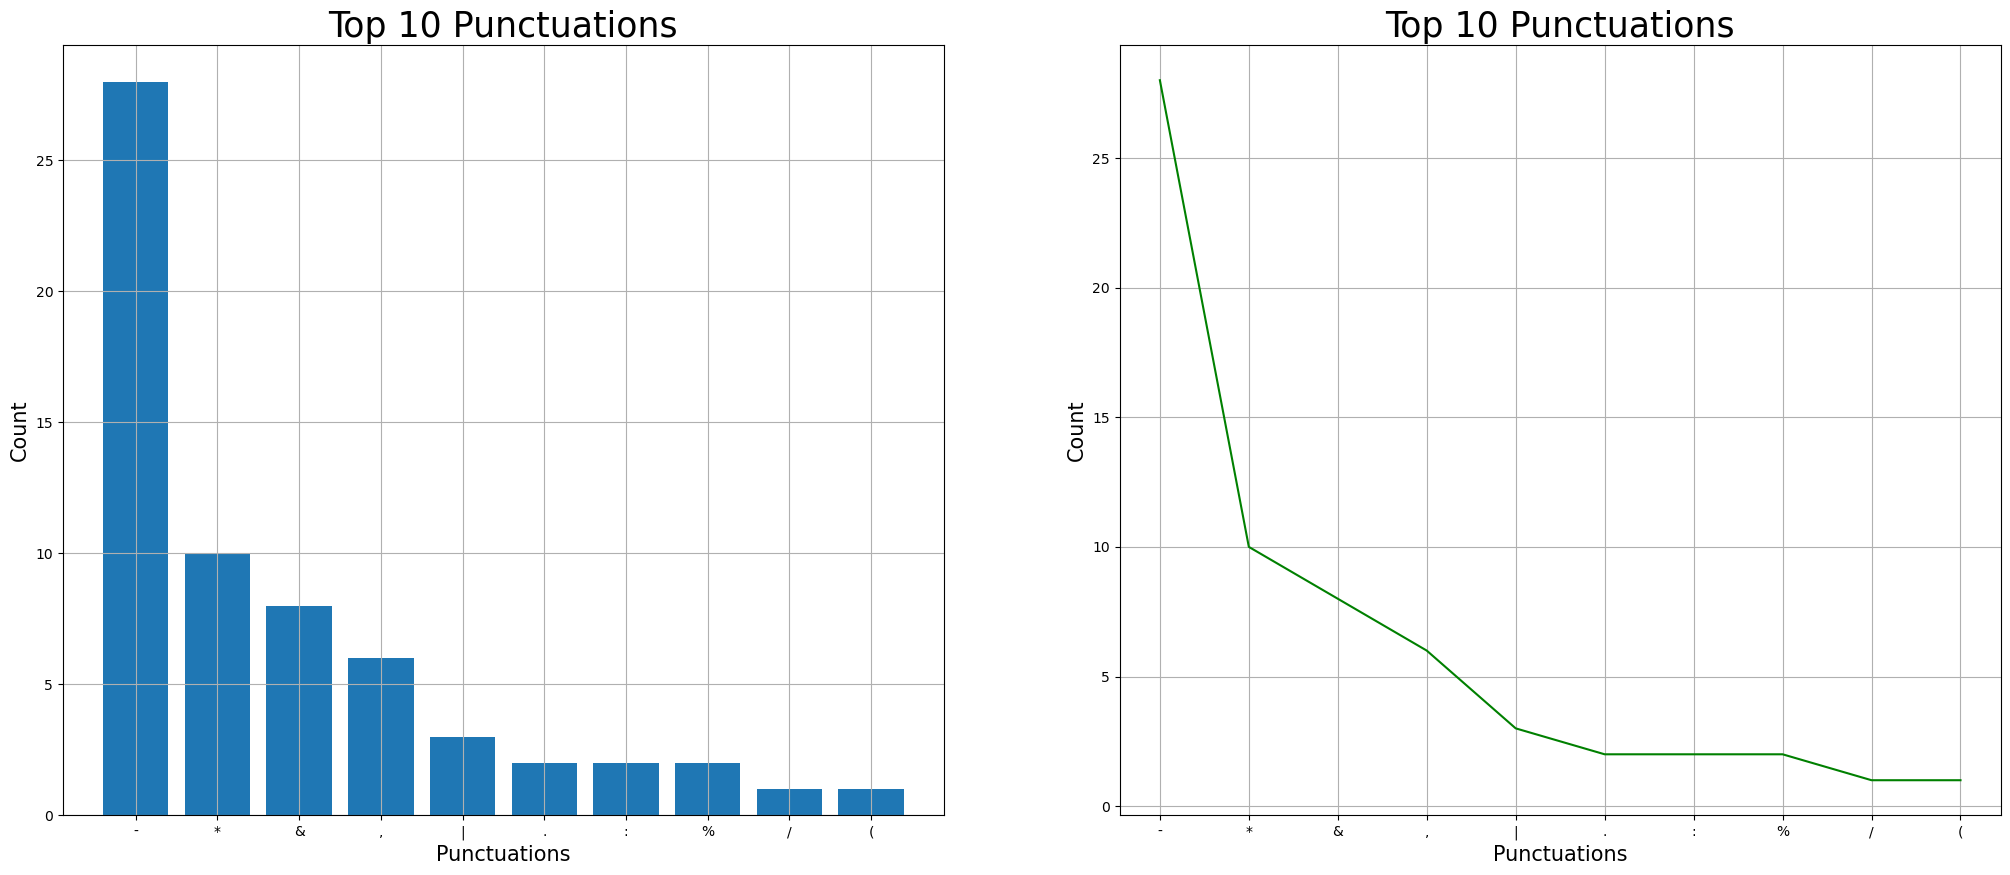

In [24]:
draw_bar_n_plot(top10,"Punctuations")

In [25]:
# Let's check stop words and punctuations in "Real Disaster Tweets"
stop_real = []
pun_real  = []
for message in train[train.target==1]["text"]:
    for word in message.split():
        if word in stop:
            stop_real.append(word)
        if word in punctuation:
            pun_real.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_real_wordlist = nltk.FreqDist(stop_real)
pun_real_wordlist =  nltk.FreqDist(pun_real)

# lets save the 10 most frequent stopwords
stop_real_top10 = stop_real_wordlist.most_common(10)
pun_real_top10  = pun_real_wordlist.most_common(10)

In [26]:
# Let's check "Fake Disaster Tweets" and create a list of stop words and punctuations
stop_fake = []
pun_fake  = []
for message in train[train.target==0]["text"]:
    for word in message.split():
        if word in stop:
            stop_fake.append(word)
        if word in punctuation:
            pun_fake.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_fake_wordlist = nltk.FreqDist(stop_fake)
pun_fake_wordlist =  nltk.FreqDist(pun_fake)

# lets save the 10 most frequent stopwords
stop_fake_top10 = stop_fake_wordlist.most_common(10)
pun_fake_top10  = pun_fake_wordlist.most_common(10)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


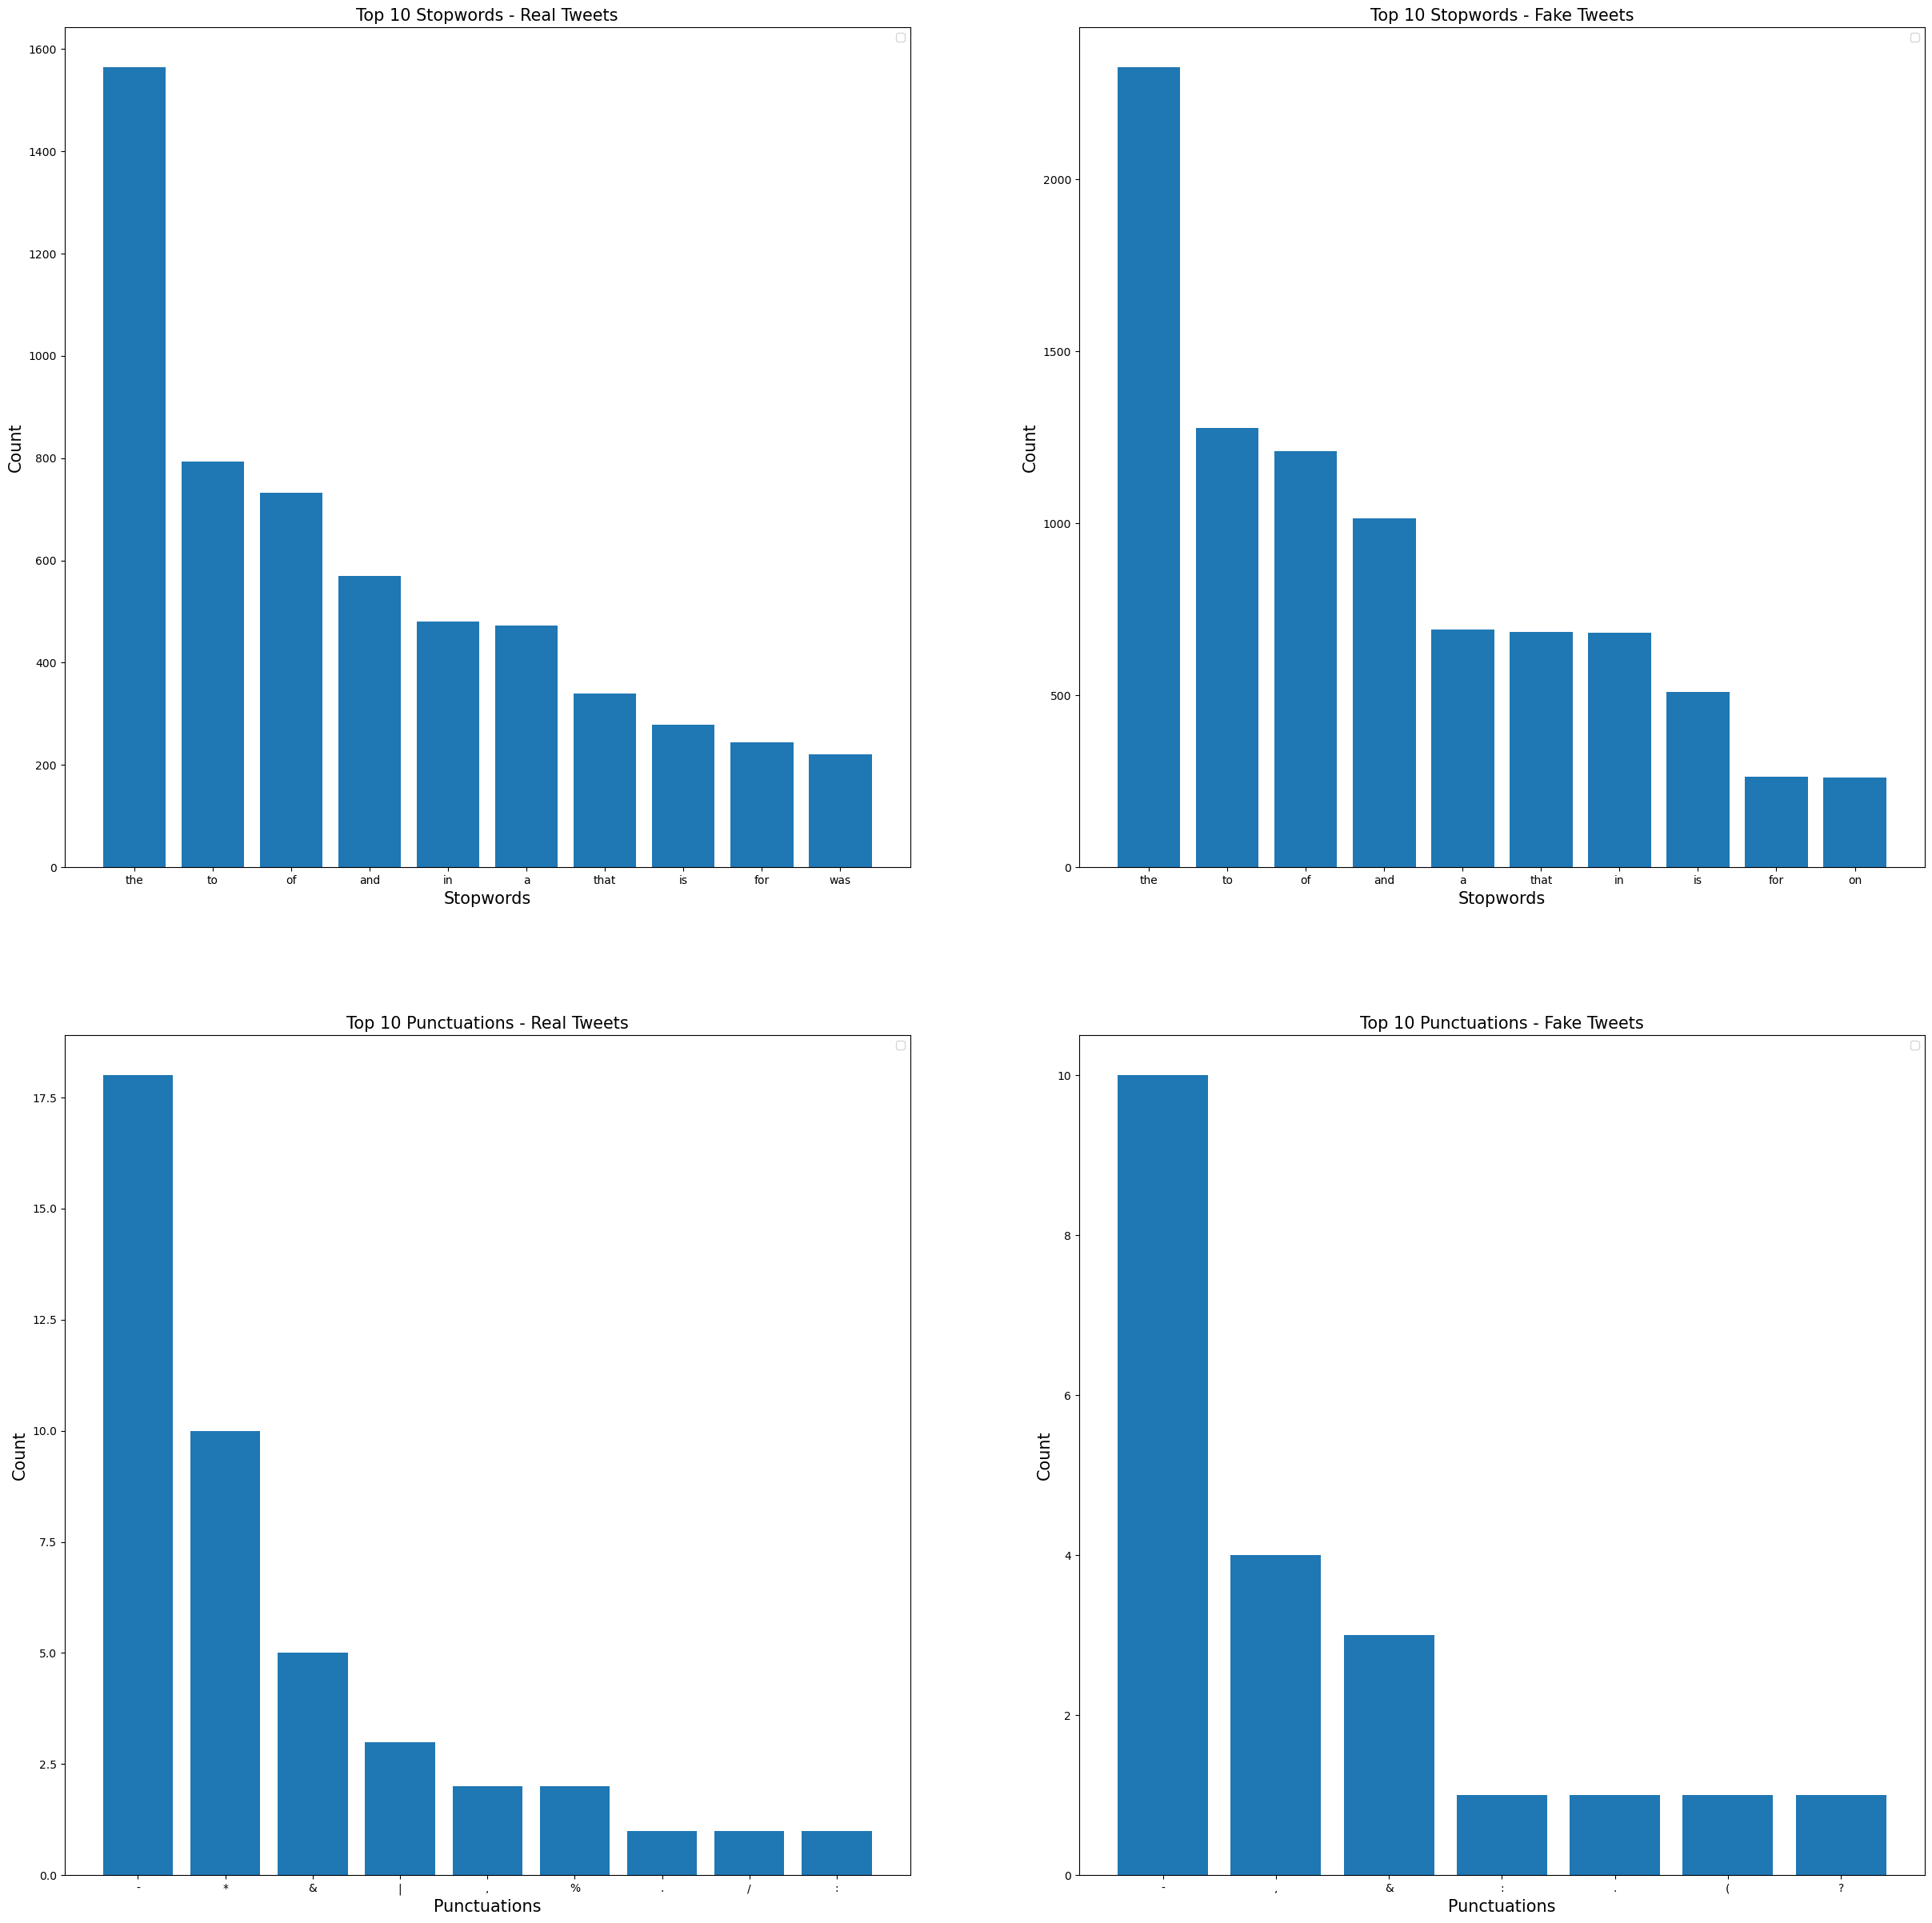

In [27]:
x_stop_real,y_stop_real=zip(*stop_real_top10)
x_pun_real, y_pun_real =zip(*pun_real_top10)

x_stop_fake,y_stop_fake=zip(*stop_fake_top10)
x_pun_fake, y_pun_fake=zip(*pun_fake_top10)


plt.figure(figsize = (30,30))
draw_bar_plot(x_stop_real,y_stop_real,"Stopwords","Count","Top 10 Stopwords - Real Tweets",1)
draw_bar_plot(x_stop_fake,y_stop_fake,"Stopwords","Count","Top 10 Stopwords - Fake Tweets",2)
draw_bar_plot(x_pun_real,y_pun_real,"Punctuations","Count","Top 10 Punctuations - Real Tweets",3)
draw_bar_plot(x_pun_fake,y_pun_fake,"Punctuations","Count","Top 10 Punctuations - Fake Tweets",4)

In [28]:
lemma = WordNetLemmatizer()

In [29]:
sw_pun = stop + punctuation

In [30]:
# function to preprocess the messages
def preprocess(tweet):
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet) # removing urls 
    tweet = re.sub('[^\w]',' ',tweet) # remove embedded special characters in words (for example #earthquake)         
    tweet = re.sub('[\d]','',tweet) # this will remove numeric characters
    tweet = tweet.lower()
    words = tweet.split()  
    sentence = ""
    for word in words:     
        if word not in (sw_pun):  # removing stopwords & punctuations                
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma    
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '             
    return(sentence)

In [31]:
# apply preprocessing functions on the train and test datasets
train['text'] = train['text'].apply(lambda s : preprocess(s))

In [32]:
# function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [33]:
# applying the function on the train and the test datasets
train['text'] = train['text'].apply(lambda s : remove_emoji(s))

In [34]:
# function to create vocab
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.text[i].split())
    return(vocab)

In [35]:
# concatenate training and testing datasets
#master=pd.concat((train,test)).reset_index(drop=True)

# call vocabulary creation function on master dataset
vocab = create_vocab(train)

# lets check the no. of words in the vocabulary
len(vocab)

6461

In [36]:
vocab.most_common(50)

[('trump', 184),
 ('people', 165),
 ('church', 144),
 ('make', 138),
 ('state', 135),
 ('would', 134),
 ('time', 121),
 ('know', 119),
 ('take', 104),
 ('even', 100),
 ('continue', 100),
 ('also', 99),
 ('president', 98),
 ('report', 92),
 ('think', 91),
 ('many', 86),
 ('call', 85),
 ('come', 84),
 ('pope', 83),
 ('american', 81),
 ('give', 78),
 ('not_propaganda', 78),
 ('iran', 75),
 ('want', 75),
 ('like', 74),
 ('claim', 74),
 ('could', 70),
 ('kavanaugh', 69),
 ('case', 69),
 ('right', 67),
 ('public', 66),
 ('world', 65),
 ('order', 64),
 ('america', 64),
 ('work', 64),
 ('tell', 64),
 ('attack', 63),
 ('leave', 62),
 ('house', 60),
 ('deal', 59),
 ('media', 59),
 ('country', 58),
 ('obama', 57),
 ('years', 57),
 ('francis', 56),
 ('well', 55),
 ('must', 54),
 ('news', 54),
 ('write', 54),
 ('first', 53)]

In [37]:
# create the final vocab by considering words with more than one occurence
final_vocab = []
min_occur = 2
for k,v in vocab.items():
    if v >= min_occur:
        final_vocab.append(k)

In [38]:
len(final_vocab)

3579

In [39]:
# function to filter the dataset, keep only words which are present in the vocab
def filter(tweet):
    sentence = ""
    for word in tweet.split():  
        if word in final_vocab:
            sentence = sentence + word + ' '
    return(sentence)

In [40]:
train['text'] = train['text'].apply(lambda s : filter(s))

In [41]:
train.text.head()

0                                             confirm 
1    declassification effort make things worse pres...
2    obama administration mislead american people c...
3    look like capture demise dark different well k...
4                                                     
Name: text, dtype: object

In [42]:
# lets create seperate datasets from real and fake tweets
propoganda = train[train.target==1].reset_index()
not_propoganda = train[train.target==0].reset_index()

In [43]:
# function to create top 100 n-grams
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["text"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top100 = esBigram_wordlist.most_common(100)
    top100 = dict(top100)
    df_ngrams = pd.DataFrame(sorted(top100.items(), key=lambda x: x[1])[::-1])
    return df_ngrams

In [44]:
# function to visualize the top 100 n-grams in real and fake disaster tweets
def draw_barplots(real,fake,title):
    plt.figure(figsize = (40,80),dpi=100)

    plt.subplot(1,2,1)
    sns.barplot(y=real[0].values[:100], x=real[1].values[:100], color='green')
    plt.title("Top 100" + title + "in Real Tweets",fontsize=15)
    
    plt.subplot(1,2,2)
    sns.barplot(y=fake[0].values[:100], x=fake[1].values[:100],color='red')
    plt.title("Top 100" + title + "in Fake Tweets",fontsize=15)

# unigrams

In [45]:
# lets create top 100 unigrams
real_unigrams = get_ngrams(propoganda,1)
fake_unigrams = get_ngrams(not_propoganda,1)

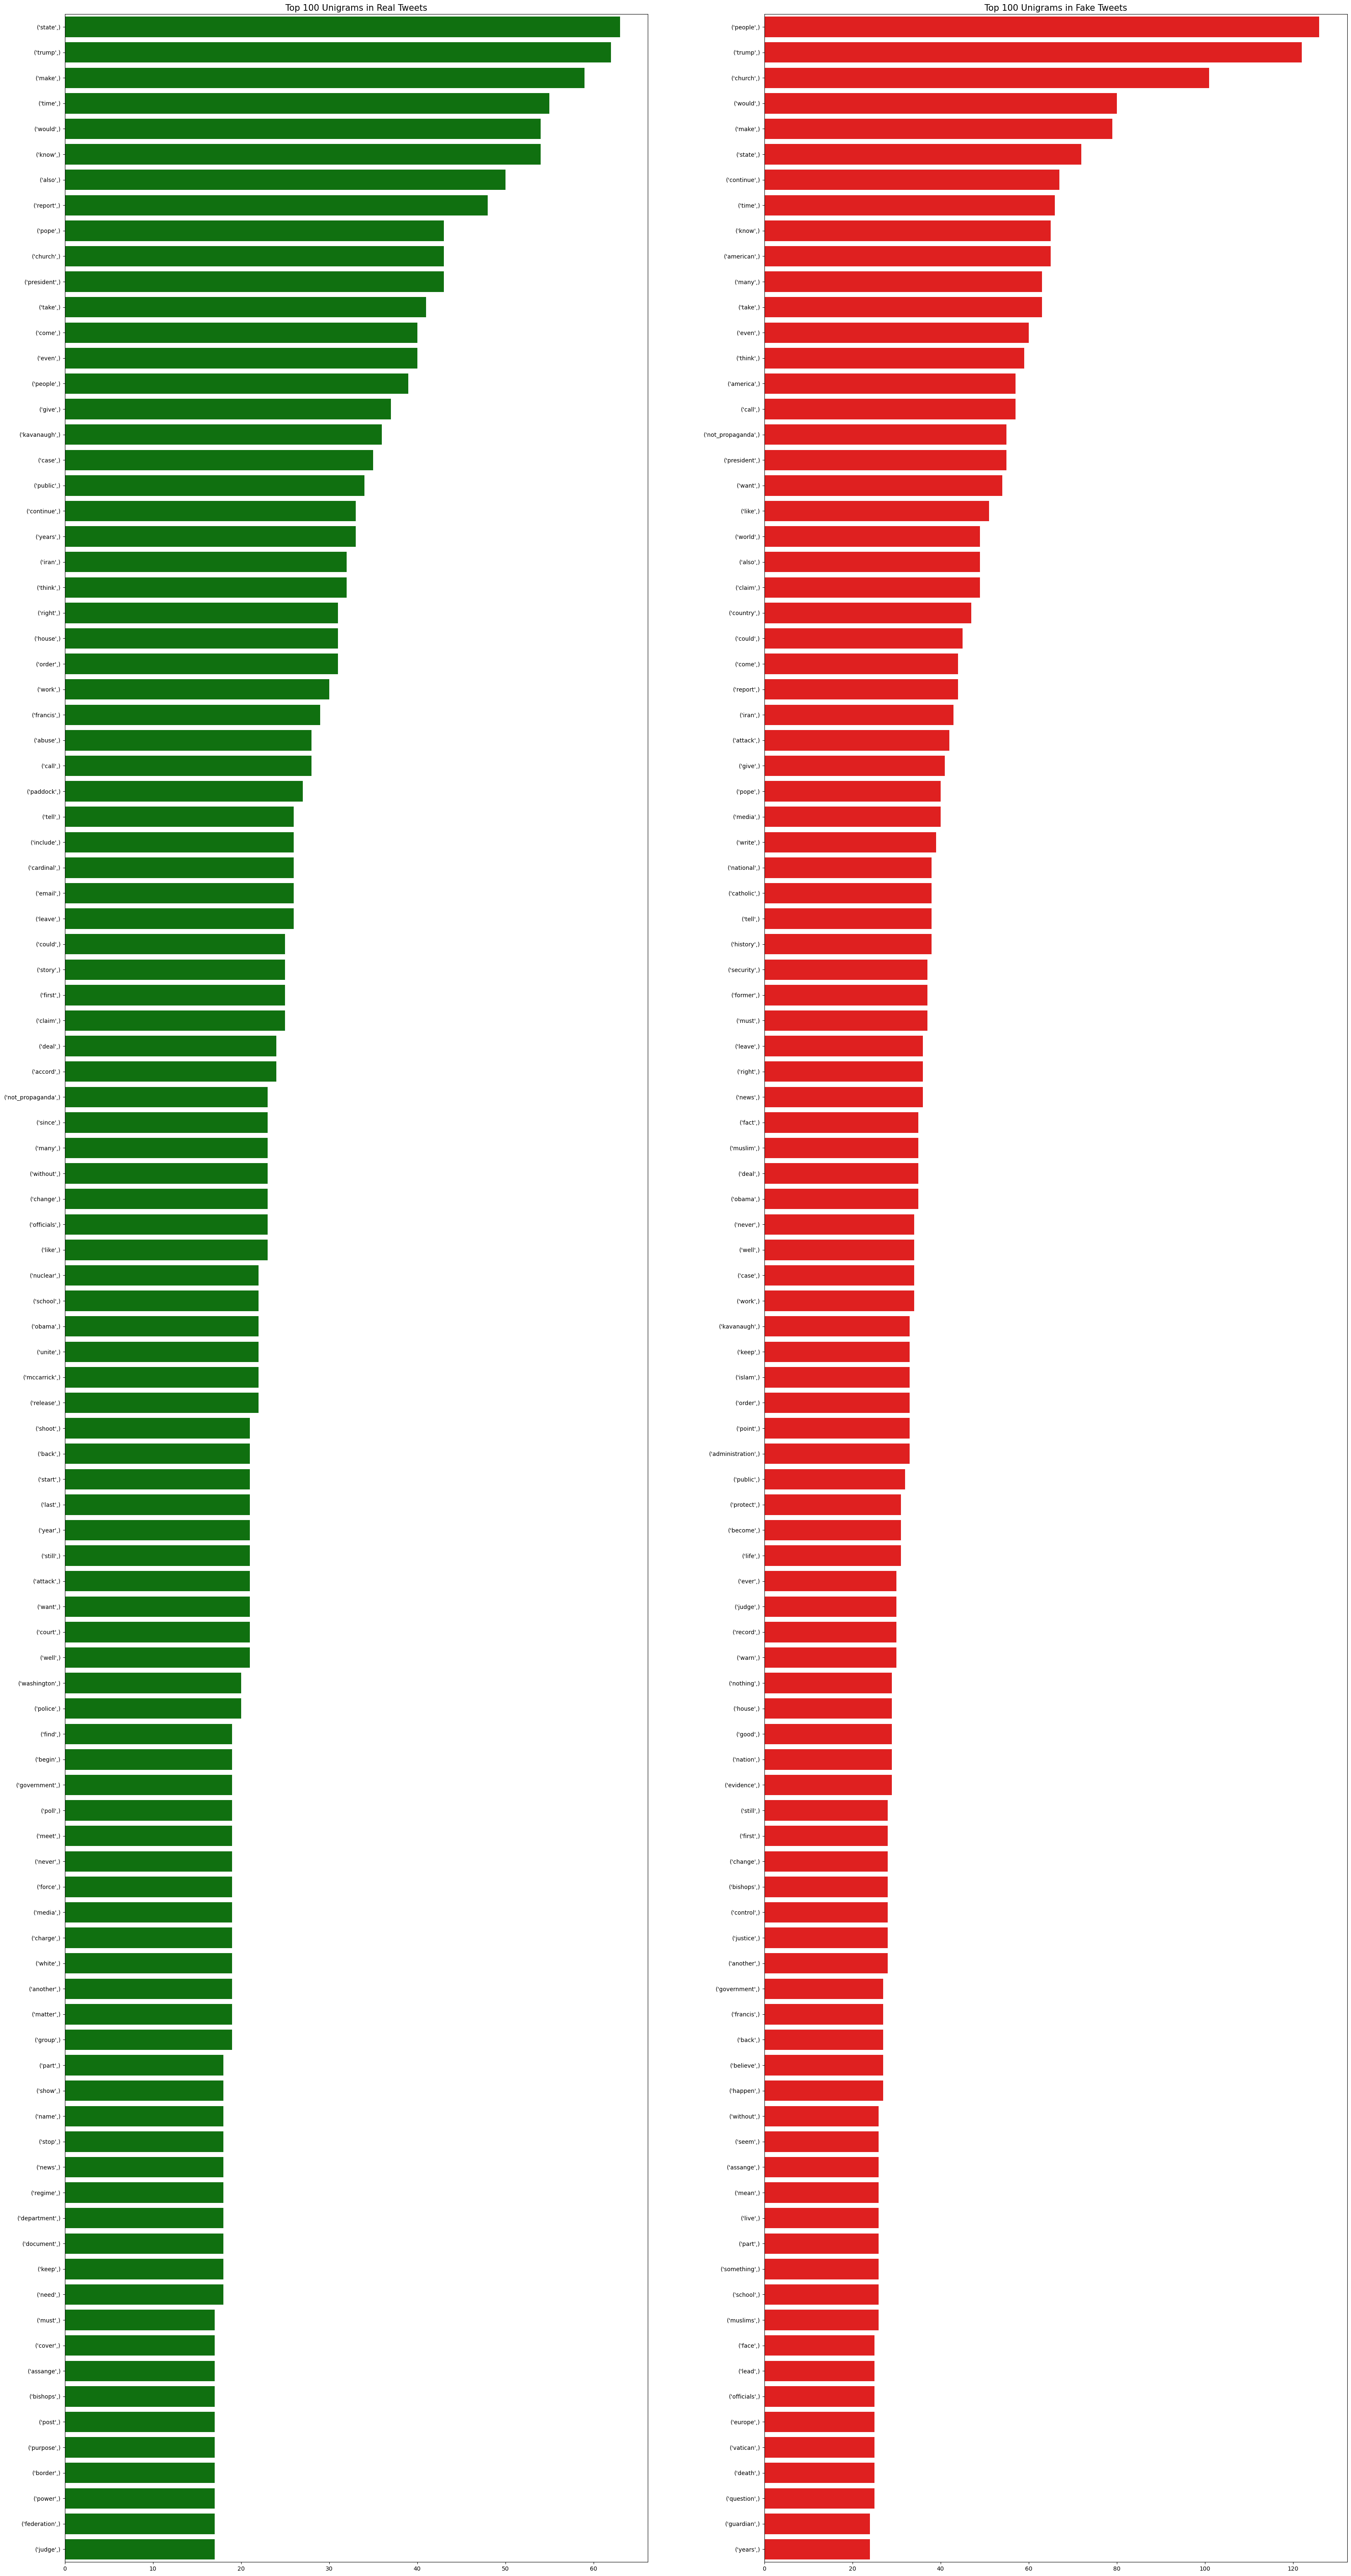

In [46]:
draw_barplots(real_unigrams,fake_unigrams," Unigrams ")

# Bigrams

In [47]:
# lets create top 100 bigrams
real_bigrams = get_ngrams(propoganda,2)
fake_bigrams = get_ngrams(not_propoganda,2)

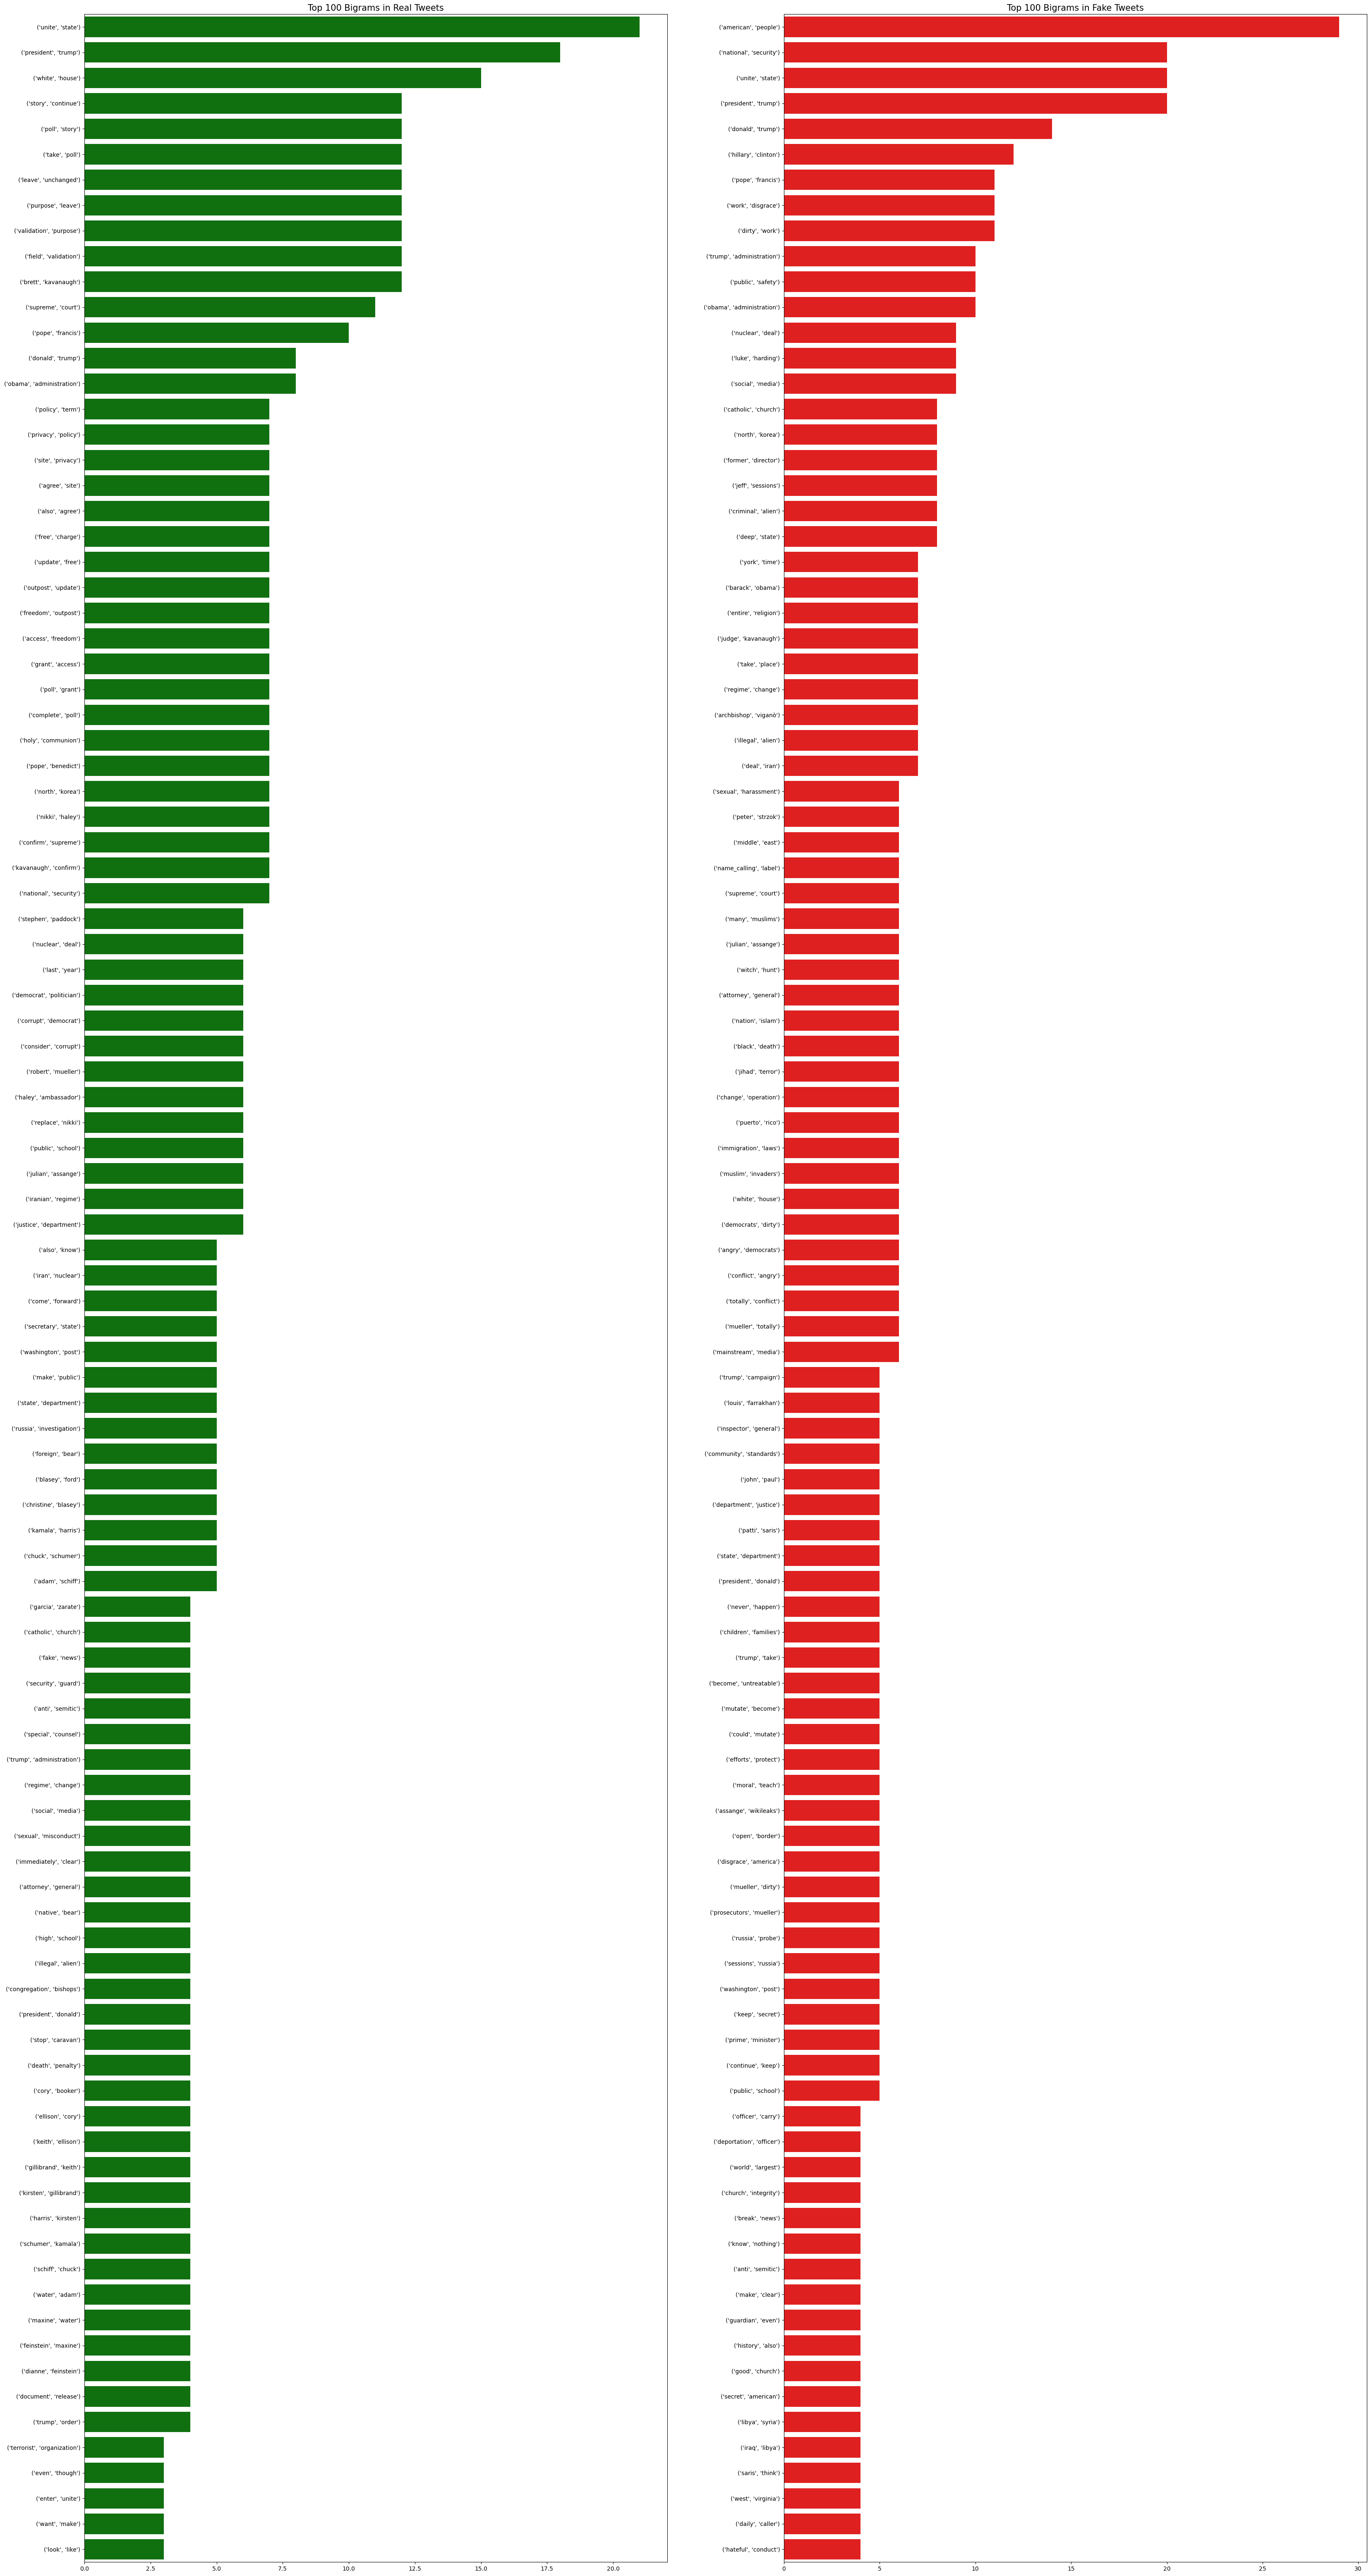

In [48]:
draw_barplots(real_bigrams,fake_bigrams," Bigrams ")

# Trigrams

In [49]:
# lets create top 100 trigrams
real_trigrams = get_ngrams(propoganda,3)
fake_trigrams = get_ngrams(not_propoganda,3)

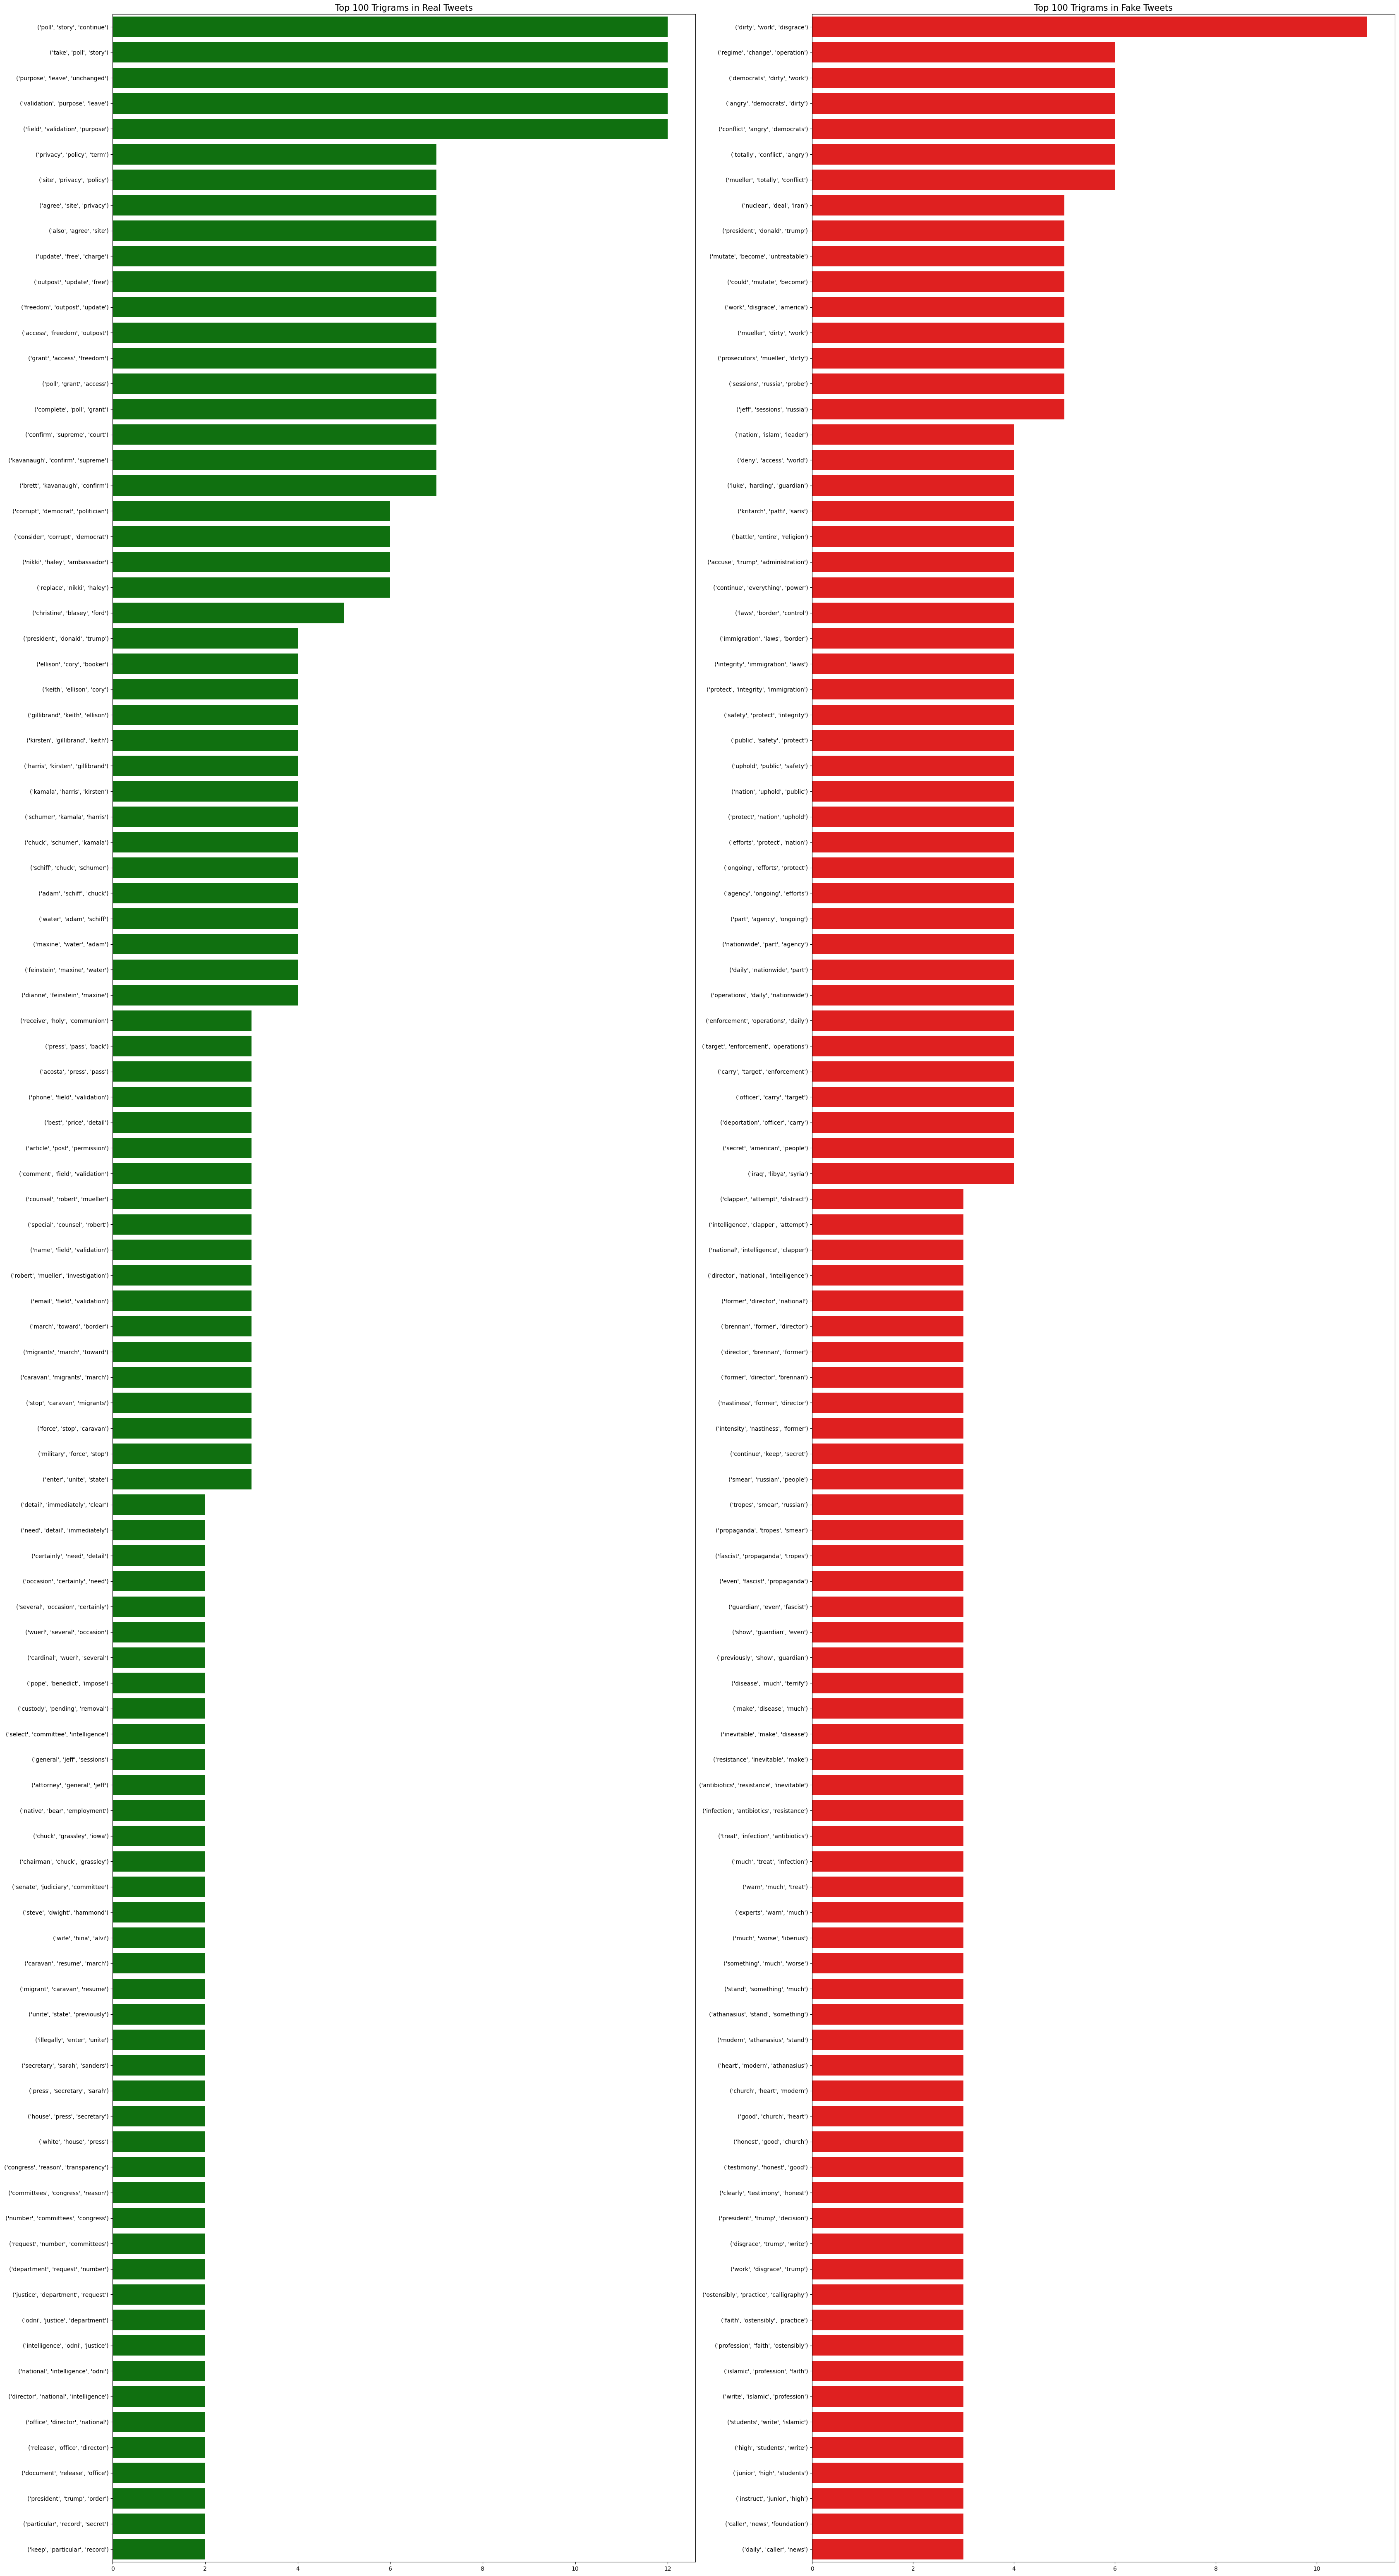

In [50]:
draw_barplots(real_trigrams,fake_trigrams," Trigrams ")

# Lets plot word cloud for real and fake tweets¶


In [51]:
def word_cloud(df):
    comment_words = '' 
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in df.text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 
        
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
        #return comment_words

    wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

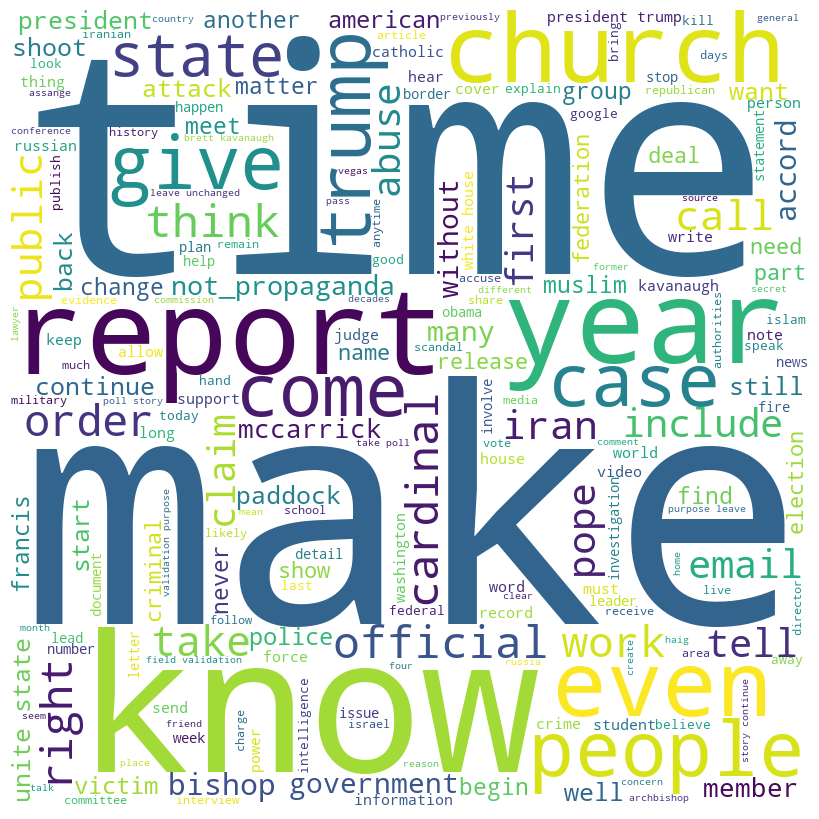

In [52]:
# world cloud for real disaster tweets
word_cloud(propoganda)

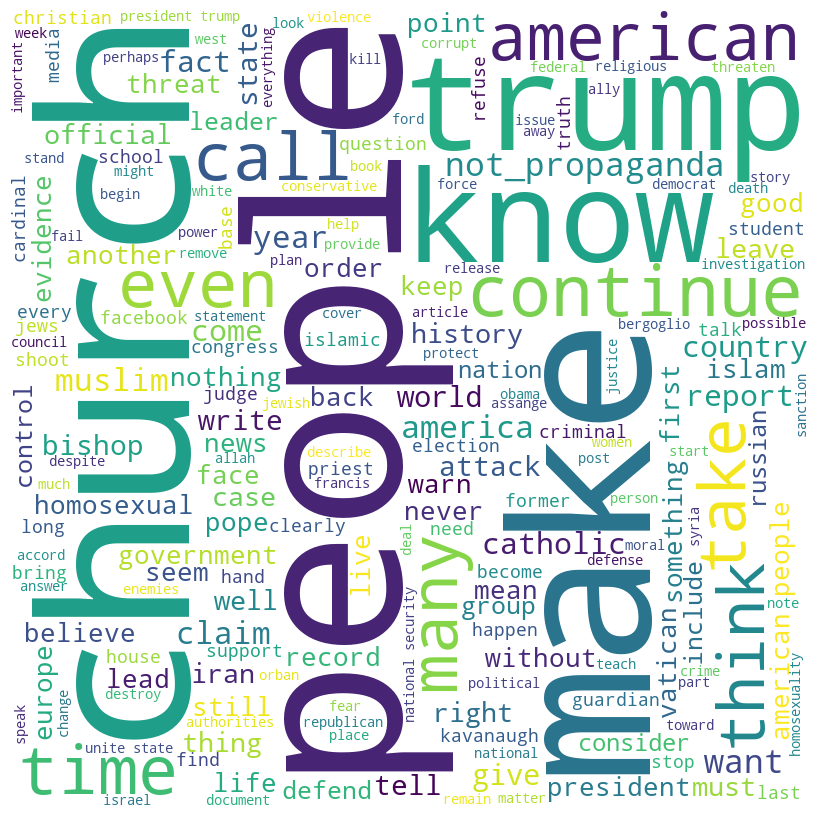

In [53]:
# world cloud for fake disaster tweets
word_cloud(not_propoganda)

# Model Building & Evaluation


In [54]:
# function to calculate f1 score for each epoch
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [55]:
# Bag of Words model
from keras.preprocessing.text import Tokenizer

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [56]:
# lets use only tweet text to build the model
X = train.text
y = train.target

In [57]:
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [58]:
# create and apply tokenizer on the training dataset
tokenizer = create_tokenizer(X_train)
X_train_set = tokenizer.texts_to_matrix(X_train, mode = 'freq')

In [59]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(128, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [get_f1])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [60]:
# create the model
n_words = X_train_set.shape[1]
model = define_model(n_words)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               451072    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 451,201
Trainable params: 451,201
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [61]:
model.fit(X_train_set,y_train,epochs=10,verbose=2)

Epoch 1/10
61/61 - 3s - loss: 0.6911 - get_f1: 0.1651 - 3s/epoch - 46ms/step
Epoch 2/10
61/61 - 1s - loss: 0.6594 - get_f1: 0.6419 - 837ms/epoch - 14ms/step
Epoch 3/10
61/61 - 1s - loss: 0.5889 - get_f1: 0.8062 - 864ms/epoch - 14ms/step
Epoch 4/10
61/61 - 1s - loss: 0.4924 - get_f1: 0.8519 - 815ms/epoch - 13ms/step
Epoch 5/10
61/61 - 1s - loss: 0.4005 - get_f1: 0.8908 - 747ms/epoch - 12ms/step
Epoch 6/10
61/61 - 1s - loss: 0.3259 - get_f1: 0.9151 - 887ms/epoch - 15ms/step
Epoch 7/10
61/61 - 1s - loss: 0.2694 - get_f1: 0.9353 - 703ms/epoch - 12ms/step
Epoch 8/10
61/61 - 1s - loss: 0.2241 - get_f1: 0.9507 - 698ms/epoch - 11ms/step
Epoch 9/10
61/61 - 1s - loss: 0.1877 - get_f1: 0.9658 - 818ms/epoch - 13ms/step
Epoch 10/10
61/61 - 1s - loss: 0.1588 - get_f1: 0.9737 - 707ms/epoch - 12ms/step


In [62]:
# prediction on the test dataset
X_test_set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
y_pred = model.predict(X_test_set)

16/16 [==============================] - 0s 3ms/step


# ANN with KERAS Word Embeddings¶


In [63]:
# Fitting a tokenizer on text will create a list of unique words with an integer assigned to it
t = Tokenizer()
t.fit_on_texts(X_train.tolist())

In [64]:
vocab_size = len(t.word_index) + 1


In [65]:
encoded_docs = t.texts_to_sequences(X_train.tolist())


In [66]:
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[ 676 2102    6 ...    0    0    0]
 [   1   26   83 ...    0    0    0]
 [ 596  381  178 ...    0    0    0]
 ...
 [ 867  420 1631 ...    0    0    0]
 [ 122  137   48 ...    0    0    0]
 [1240  444  490 ...    0    0    0]]


In [67]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100,  input_length=100, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[get_f1])
# summarize the model
model.summary()
# fit the model
model.fit(padded_docs, y_train, epochs=50, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          352300    
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 362,301
Trainable params: 10,001
Non-trainable params: 352,300
_________________________________________________________________


In [68]:
loss, accuracy = model.evaluate(padded_docs, y_train, verbose=0)

In [69]:
print(accuracy)


0.7773141860961914


# Lstm with word embedding

In [70]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D


In [71]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(512, embed_dim,input_length = X_train_set.shape[1]))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='RMSprop')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3523, 128)         65536     
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense_3 (Dense)             (None, 1)                 197       
                                                                 
Total params: 320,533
Trainable params: 320,533
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 200
hist = model.fit(X_train_set,y_train,epochs = 57, batch_size=batch_size, verbose = 2)

Epoch 1/57


# Bert model

In [ ]:
### Add tokens to the data make it BERT compatible
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
import tensorflow_hub as hub

In [ ]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

In [ ]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)